<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/part/RO1_SO2_Identification_Part_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REIMS Visualization

Mount the google drive where the closed-source dataset is safely and privately stored.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive')

Mounted at /content/drive


['Colab Notebooks',
 'University',
 'AI',
 'profile.jpg',
 'personal',
 'ass3_example_solutions_marking_guides_2023_V2.docx',
 'JAPA101: Handwriting Assignment - Part 2 - Creative Writing and Reflection.gdoc']

## Load the data

To load an xlsx file into memory using Python, you can use the pandas library. The pandas library provides a read_excel() function that can be used to read an xlsx file into a DataFrame object.

This code will join the strings in the path_array variable and print the resulting joined path. The output will be /usr/local/bin.

Note that the * operator is used to unpack the path_array variable so that each element in the array is passed as a separate argument to the os.path.join() function. This allows the function to join the strings in the array together to form a valid path.

To convert the feature names (column names) of a Pandas DataFrame to strings, you can use the DataFrame.columns.astype(str) method. This will convert the column names to strings and return a new index object.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)

# Load the dataset
data = pd.read_excel(path)

# Statistical Methods


# Classification - Traditional Machine Learning Techniques

# CNN

## Hyperparameters

In [109]:
# Hyperparameters
learning_rate = 1E-4 #@param {type:"integer"}
batch_size = 32 # @param {type:"integer"}
epochs = 100000 # @param {type:"integer"}

# Pre-processing

In [110]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):

    def __init__(self, samples, labels):
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.labels = torch.tensor([np.array(ys) for ys in labels], dtype=torch.float32)

        # Normalize the features to be between in [0,1]
        self.samples = F.normalize(self.samples, dim = 0)

        # full_batch_size = self.samples.shape[0]  # Get the batch size
        # in_channels = 1  # The number of channels in each item
        # sequence_length = self.samples[0].shape[0]  # Get the sequence length
        # # Reshape the input data
        # self.samples = self.samples.view(full_batch_size, in_channels, sequence_length)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
y = data['m/z'].apply(lambda x:
                          [1,0,0,0,0,0] if 'Fillet' in x
                    else ([0,1,0,0,0,0] if 'Heads' in x
                    else ([0,0,1,0,0,0] if 'Livers' in x
                    else ([0,0,0,1,0,0] if 'Skins' in x
                    else ([0,0,0,0,1,0] if 'Guts' in x
                    else ([0,0,0,0,0,1] if 'Frames' in x
                    else None ))))))  # Labels (0 for Hoki, 1 for Moki)
xs = []
ys = []
for (x,y) in zip(X.to_numpy(),y):
    if y is not None:
       xs.append(x)
       ys.append(y)
X = np.array(xs)
y = np.array(ys)

# Evaluation parameters.
train_split = 0.7
val_split = 0.5 # 1/2 of 20%, validation and test, 10% and 10%, respectively.

# Step 2: Split your dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=(1-train_split), random_state=21998)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split, random_state=21998)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

assert train_dataset.samples.shape[0] == train_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert val_dataset.samples.shape[0] == val_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert test_dataset.samples.shape[0] == test_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."

# Step 4: Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# calculate steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size
# when batch_size greater than dataset size, avoid division by zero.
train_steps = max(1, train_steps)
val_steps = max(1, val_steps)

[INFO] Reading the dataset.


# CNN

[INFO] Initialize cuda environment
[INFO] Initializing the LeNet model
[INFO] Training the network
[INFO] EPOCH: 1/10000
Train loss: 2.025207, Train accuracy: 0.2500
Val loss: 1.765244, Val accuracy: 0.4000

[INFO] EPOCH: 51/10000
Train loss: 0.374726, Train accuracy: 1.0000
Val loss: 1.168903, Val accuracy: 0.6000

[INFO] EPOCH: 101/10000
Train loss: 0.361210, Train accuracy: 1.0000
Val loss: 1.186914, Val accuracy: 0.4000

[INFO] EPOCH: 151/10000
Train loss: 0.341769, Train accuracy: 1.0000
Val loss: 1.153128, Val accuracy: 0.4000

[INFO] EPOCH: 201/10000
Train loss: 0.326983, Train accuracy: 1.0000
Val loss: 1.172555, Val accuracy: 0.4000

[INFO] EPOCH: 251/10000
Train loss: 0.314018, Train accuracy: 1.0000
Val loss: 1.160449, Val accuracy: 0.4000

[INFO] EPOCH: 301/10000
Train loss: 0.311253, Train accuracy: 1.0000
Val loss: 1.160161, Val accuracy: 0.4000

[INFO] EPOCH: 351/10000
Train loss: 0.311299, Train accuracy: 1.0000
Val loss: 1.144068, Val accuracy: 0.4000

[INFO] EPOCH: 40

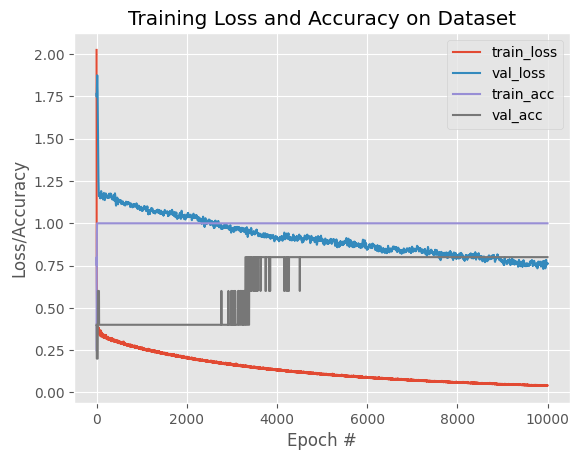

In [106]:
import torch
import torch.nn
import torch.nn.functional as F
from torch.nn import Module, Conv1d, Linear, MaxPool1d, AdaptiveAvgPool1d, Dropout, ReLU, LeakyReLU, GELU, Sigmoid, LogSoftmax, Softmax, CrossEntropyLoss, BatchNorm1d, LayerNorm
from torch import flatten
from torch.optim import Adam, AdamW
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time


class LeNet(Module):


    def __init__(self, shape):
        """
        A simple convolutional neural network, based on LeNet from (LeCun 1989)

        Args:
            shape (np-like): the architecture for the CNN.
            for
                (input, hidden, output) = shape
            where
                input - number of features.
                hidden - dimensions for hidden layer(s).
                output - number of classes.

        References:
        1. LeCun, Y. (1989). Generalization and network design strategies.
            Connectionism in perspective, 19(143-155), 18.
        2. LeCun, Y., Boser, B., Denker, J., Henderson, D., Howard,
            R., Hubbard, W., & Jackel, L. (1989).
            Handwritten digit recognition with a back-propagation network.
            Advances in neural information processing systems, 2.
        3. LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E.,
            Hubbard, W., & Jackel, L. D. (1989).
            Backpropagation applied to handwritten zip code recognition.
            Neural computation, 1(4), 541-551.
        """
        super(LeNet, self).__init__()
        self.shape = shape
        (input, hidden, output) = shape
        activation = GELU()

        # First convolutional layer
        self.conv1 = Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.batchnorm1 = BatchNorm1d(64)
        self.activation1 = activation
        self.maxpool1 = MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = Dropout(p=0.5)

        # Second convolutional layer
        self.conv2 = Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.batchnorm2 = BatchNorm1d(128)
        self.activation2 = activation
        self.maxpool2 = MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = Dropout(p=0.5)

        # # # Third convolutional layer
        # self.conv3 = Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        # self.activation3 = LeakyReLU()
        # self.maxpool3 = MaxPool1d(kernel_size=2, stride=2)
        # self.dropout3 = Dropout(p=0.5)

        # # Fourth convolutional layer
        # self.conv4 = Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        # self.activation4 = LeakyReLU()
        # self.maxpool4 = MaxPool1d(kernel_size=2, stride=2)
        # self.dropout4 = Dropout(p=0.5)

        # Fully connected layer 1
        self.flatten = lambda x: flatten(x, 1)
        self.fc1 = Linear(in_features=32256, out_features=800)  # With 4 convolutional layers
        self.dropout5 = Dropout(p=0.5)

        # self.fc1 = Linear(in_features=8064, out_features=800) # With 2 convolutional layers

        self.batchnorm3 = BatchNorm1d(800)
        self.activation5 = activation

        # # Fully connetcted layer 2
        # self.fc2 = Linear(in_features=800, out_features=500)
        # self.activation6 = activation

        # Fully connected layer 3
        self.fc3 = Linear(in_features=800, out_features=output)
        # Output layer.
        self.batchnorm4 = BatchNorm1d(output)
        self.activation7 = LogSoftmax(dim=1)
        # self.softmax = Softmax()

        self.layers = layers = [
            self.conv1, self.batchnorm1, self.activation1, self.maxpool1, # First layer
            self.dropout1, # Regularization
            self.conv2, self.batchnorm2, self.activation2, self.maxpool2, # Second layer
            self.dropout2, # Regularization
            # self.conv3, self.activation3, self.maxpool3, # Third layer
            # self.dropout3, # Regularization
            # self.conv4, self.activation4, self.maxpool4, # Fourth layer
            # self.dropout4, # Regularization
            self.flatten,
            self.fc1, self.batchnorm3, self.activation5, # Fifth layer
            self.dropout5,
            # self.fc2, self.activation6, # Sixth layer
            self.fc3, self.batchnorm4, self.activation7 # Seventh layer
        ]


    def forward(self, x):
        # Forward pass of the convolutional neural network.
        for layer in self.layers:
            x = layer(x)
        return x

print("[INFO] Initialize cuda environment")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPUs if available.

print("[INFO] Initializing the LeNet model")

input = batch_size
num_channels = 1
output = 6
model = LeNet(
    shape = (
        input, # Input
         [num_channels, batch_size, batch_size, 124, 50], #Hidden
        output) # Output
)

model.to("cuda")
# optimizer = Adam(model.parameters(), lr=learning_rate)
optimizer = AdamW(model.parameters(), lr=learning_rate, betas= (0.9, 0.999))
loss_function = CrossEntropyLoss()

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

print("[INFO] Training the network")
startTime = time.time()

def pad_smaller_batch(batch, batch_size):
    # Pad smaller batches with zeros to match the expected batch size

    if len(batch[0]) < batch_size:
       batch = [F.pad(tensor, (0, 0, 0, batch_size - tensor.size(0))) for tensor in batch]
    return batch

# Training the CNN model.
for e in range(0, epochs):
    # Puts the model in train mode.
    model.train()

    total_train_loss = 0
    total_val_loss = 0

    train_correct = 0
    val_correct = 0

    # Training routine
    # Note: the benefit of using torch's DataLoader,
    # is that is automatically yields batches of training data.
    # This makes it ammeneable to training a deep neural network.
    for (x,y) in train_loader:
        (x,y) = (x.to(device), y.to(device))
        prediction = model(x.unsqueeze(1))
        loss = loss_function(prediction, y)
        optimizer.zero_grad()  # 1. Zero out the gradients
        loss.backward() # 2. Perform a backwards pass.
        optimizer.step() # 3. Update the weights.
        total_train_loss += loss
        train_correct += (prediction.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # Evalulation routine
    # no_grad() turns off gradient tracking and computation.
    with torch.no_grad():
        # Puts the model in evaluation mode.
        model.eval()
        for (x,y) in val_loader:
            (x,y) = (x.to(device), y.to(device))
            prediction = model(x.unsqueeze(1))
            total_val_loss = loss_function(prediction,y)
            val_correct += (prediction.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = total_train_loss / train_steps
    avgValLoss = total_val_loss / val_steps

    # calculate the training and validation accuracy
    trainCorrect = train_correct / len(train_loader.dataset)
    valCorrect = val_correct / len(val_loader.dataset)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # Print telemetry every 50 epochs, to avoid spamming standard out.
    if e % 50 == 0:
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

    # # Early stopping
    # if valCorrect >= 1.00 and trainCorrect >= 1.00:
    #     print("[INFO] Finished on => EPOCH: {}/{}".format(e + 1, epochs))
    #     print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    #     print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))
    #     break;

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("model_accuracy.png")
# serialize the model to disk
# torch.save(model, "model.h5")

In [108]:
# switch off autograd
with torch.no_grad():
    # loop over the test set
    datasets = [("train", train_loader), ("validation", val_loader), ("test", test_loader)]
    for name, dataset in datasets:
        for (x,y) in dataset:
            (x,y) = (x.to(device), y.to(device))
            y_true = y
            pred = model(x.unsqueeze(1))
            y_pred = pred.argmax(axis=1).cpu().numpy()
            test_correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            print(f"[INFO] {name} accuracy {test_correct} / {len(x)}")

[INFO] train accuracy 20.0 / 20
[INFO] validation accuracy 4.0 / 5
[INFO] test accuracy 2.0 / 5
